<a href="https://colab.research.google.com/github/adamzbikowski/Process-Mining-Dissertation/blob/main/pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pipeline 1: predicting missing values for activity

## Section 1: Loading event log

In [1]:
# installing prerequisites
# certain packages are not installed by default on google colab
!pip install pm4py


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 14.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for stringdist: filename=StringDist-1.0.9-cp38-cp38-linux_x86_64.whl size=24942 sha256=36ddbc69b247443b05bec8b9a20683dc5eae04c4381d6042814c8de8d59d0ef8
  Stored in directory: /root/.cache/pip/wheels/7a/64/e2/16f6a25a62a78f951c1715adb24ba2271ae9d7872f42378c3a
Successfully built stringdist


In [2]:
from google.colab import auth
auth.authenticate_user()

In [3]:
# this assumes that the user has access to the mimic-iii dataset 
# replace project name to the project containing mimic-iii
project_name = "processmining-367815" 
from google.cloud import bigquery
client = bigquery.Client(project=project_name)

In [4]:
import requests

# read a query from the github repository
# change depending on which branch the queries have been pushed to
branch = "sql-queries" 
# change this to change which query is being used
query_name = "event_log_mvp.sql"
url = f"https://raw.githubusercontent.com/adamzbikowski/Process-Mining-Dissertation/{branch}/sql_queries/{query_name}"
query_bytes = requests.get(url).content

# we must now decode this to turn the query into a string 
query = query_bytes.decode("utf-8")

In [5]:
import pandas as pd

# loading event log from mimic-iii using bigQuery
event_log = client.query(query).to_dataframe()
# convert timestamp from object to datetime64
event_log["timestamp"] = pd.to_datetime(event_log["timestamp"])
event_log


,patient,activity,timestamp
0,109129,Discharged,2188-08-01 12:04:00
1,121510,Discharged,2133-04-23 15:52:00
2,106469,Discharged,2109-02-23 12:01:00
3,133732,Discharged,2167-10-16 13:13:00
4,119601,Discharged,2198-02-20 15:33:00
...,...,...,...
140355,121061,Transfer,2126-07-06 22:00:47
140356,150357,Transfer,2168-09-25 13:23:15
140357,166021,Transfer,2146-09-15 03:16:45
140358,137177,Transfer,2193-01-07 16:03:50


## Section 2: Process Discovery

In [6]:
import pm4py as pm

event_log = pm.format_dataframe(event_log, case_id='patient', activity_key='activity', timestamp_key='timestamp')
# lets get some information about the event log
n_events = len(event_log)
n_cases = len(event_log.patient.unique())
start_events = pm.get_start_activities(event_log)
end_events = pm.get_end_activities(event_log)
print(f"Number of cases: {n_cases}\nNumber of events: {n_events}")
print(f"Start events: {start_events}\nEnd events: {end_events}")


<ipython-input-6-aedec179434f>:3: DeprecatedWarning: format_dataframe is deprecated as of 2.3.0 and will be removed in 3.0.0. the format_dataframe function does not need application anymore.
  event_log = pm.format_dataframe(event_log, case_id='patient', activity_key='activity', timestamp_key='timestamp')


Number of cases: 42652
Number of events: 140360
Start events: {'Admitted': 36881, 'Transfer': 5716, 'Discharged': 55}
End events: {'Discharged': 42563, 'Transfer': 85, 'Admitted': 4}


In [7]:
# lets improve the event log by filtering out the cases that do not start or end with a patient being admitted or discharged
# this will simplify the model

event_log = pm.filter_start_activities(event_log, ['Admitted'])
event_log = pm.filter_end_activities(event_log,['Discharged'])

In [8]:
net, initial_marking, final_marking = pm.discover_petri_net_alpha(event_log)

/usr/local/lib/python3.8/dist-packages/pm4py/algo/discovery/dfg/adapters/pandas/df_statistics.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[start_timestamp_key] = df[timestamp_key]


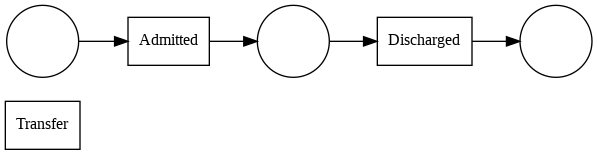

In [9]:
import graphviz
pm.view_petri_net(petri_net=net)

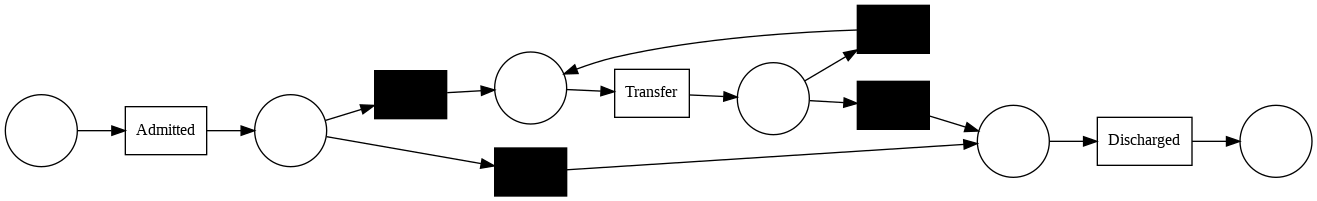

In [10]:
# inductive miner
# much better result than when using alpha miner, petri net 
net, initial_marking, final_marking = pm.discover_petri_net_inductive(event_log)
pm.view_petri_net(petri_net=net)

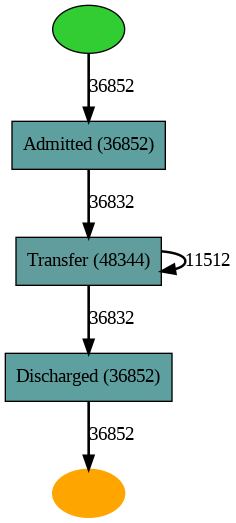

In [11]:
# heuristic miner
heu_net = pm.discover_heuristics_net(event_log, dependency_threshold=0.99)
pm.view_heuristics_net(heu_net)

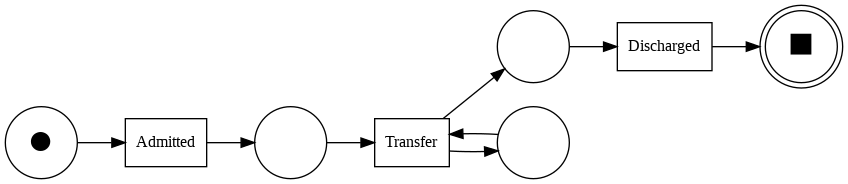

In [12]:
# petri net from heuristics miner
net, im, fm = pm.discover_petri_net_heuristics(event_log, dependency_threshold=0.99)
pm.view_petri_net(net, im, fm)

## Section 3: Data Pre Processing



In [13]:
from pandas.core.window.ewm import partial
import random
# select the first 100 cases to test the LSTM methodology
# lets first add a trace column to the event_log
event_log['trace'] = event_log.groupby(['patient']).ngroup()

# we can now select 100 random traces,
# this will be repeated with a a larger number of traces
# lets first initialise a random seed
random.seed(9)
num_traces = 100
random_traces = []

for i in range(0,num_traces):
  random_traces.append(random.randrange(0,n_cases))

df = event_log[event_log['trace'].isin(random_traces)]
partial_el = df[['trace', 'activity', 'timestamp' ]].reset_index(drop=True)
partial_el

,trace,activity,timestamp
0,253,Admitted,2187-07-25 11:58:00
1,253,Transfer,2187-07-25 11:59:27
2,253,Transfer,2187-07-26 11:56:57
3,253,Discharged,2187-07-30 13:10:00
4,345,Admitted,2108-01-10 22:33:00
...,...,...,...
291,36376,Admitted,2173-05-31 14:23:00
292,36376,Transfer,2173-05-31 14:27:08
293,36376,Transfer,2173-05-31 20:36:45
294,36376,Transfer,2173-06-01 13:11:12


In [14]:
# lets represent each activity using a statically defined number
# this will prevent the need for using an embedding layer when traing the LSTM
unique_activities = partial_el['activity'].unique()
encode_activity = {unique_activities[i-1] : i for i in range(1,len(unique_activities)+1)}

# lets also create a second dictionary that will be used to decode predicted activities
decode_activity = {i : unique_activities[i-1] for i in range(1, len(unique_activities)+ 1)}
encode_activity, decode_activity


({'Admitted': 1, 'Transfer': 2, 'Discharged': 3},
 {1: 'Admitted', 2: 'Transfer', 3: 'Discharged'})

In [15]:
import numpy as np
# create a new labeled data frame

def label(el):
  # initialise data frame 
 
  prefix_arr, suffix_arr, label_arr = [], [], []
  labeled_arr = []
  unique_traces = el['trace'].unique()
  traces = {x : pd.DataFrame() for x in unique_traces} 

  for t in unique_traces:
    traces[t] = el[:][el.trace == t]  
  
  for t in unique_traces:
    df = traces[t].sort_values(by='timestamp')
    activities = []
    for i in df.index:
      activity = encode_activity.get(df['activity'][i])
      activities.append(activity)
    
    length = len(activities)
    
    for i in range(length):

      # prefix = activities[:i]
      label = activities[i]
      prefix = activities[:i]
      suffix = []

      if i != length - 1:
        suffix = activities[i+1:]
      padding = []

      while len(prefix) + len(padding) < 3:
        padding.append('0')
      
      prefix = padding + prefix
        
      while len(suffix) < 3:
        suffix.append('0')

      prefix_arr.append(np.array(prefix[0:3], dtype=int))
      suffix_arr.append(np.array(suffix[0:3], dtype=int))
      label_arr.append(label)

  return pd.DataFrame({'prefix' : prefix_arr, 
                       'suffix' : suffix_arr,
                       'label' : label_arr})
 

In [16]:
from sklearn.model_selection import train_test_split

# label event log
labeled_el = label(partial_el)

# split event log into a train and test set  
pct_train = 0.8
train_el, test_el  = train_test_split(labeled_el, train_size=pct_train, random_state=9)
train_el


,prefix,suffix,label
69,"[0, 0, 1]","[3, 0, 0]",2
54,"[0, 1, 2]","[0, 0, 0]",3
99,"[1, 2, 2]","[0, 0, 0]",3
103,"[0, 0, 0]","[2, 2, 3]",1
240,"[0, 0, 0]","[2, 2, 3]",1
...,...,...,...
65,"[0, 0, 0]","[2, 3, 0]",1
125,"[0, 0, 1]","[3, 0, 0]",2
251,"[0, 0, 0]","[2, 3, 0]",1
56,"[0, 0, 1]","[2, 3, 0]",2


In [17]:
from copy import deepcopy

# declare the label of each activity in the test set as missing
# return actual labels as targets array for validation
def missing(el):
 
  # need to deepcopy targets to derefrence them from dataframe  
  targets = deepcopy(el['label'])
  el['label'] = 'missing'
  return el, targets.to_numpy()

In [18]:
# train_targets = train_el['label'].to_numpy()
test_el, test_targets = missing(test_el)
test_el, test_targets

(        prefix     suffix    label
 95   [0, 1, 2]  [0, 0, 0]  missing
 127  [0, 0, 0]  [2, 3, 0]  missing
 31   [0, 1, 2]  [2, 2, 2]  missing
 83   [1, 2, 2]  [2, 3, 0]  missing
 291  [0, 0, 0]  [2, 2, 2]  missing
 133  [1, 2, 2]  [0, 0, 0]  missing
 89   [0, 0, 0]  [2, 2, 3]  missing
 123  [1, 2, 2]  [0, 0, 0]  missing
 124  [0, 0, 0]  [2, 3, 0]  missing
 162  [0, 1, 2]  [0, 0, 0]  missing
 88   [0, 1, 2]  [0, 0, 0]  missing
 105  [0, 1, 2]  [3, 0, 0]  missing
 281  [0, 1, 2]  [0, 0, 0]  missing
 37   [0, 0, 1]  [2, 3, 0]  missing
 177  [0, 0, 1]  [2, 3, 0]  missing
 15   [0, 1, 2]  [3, 0, 0]  missing
 201  [0, 0, 1]  [2, 3, 0]  missing
 152  [0, 0, 1]  [2, 2, 3]  missing
 172  [0, 1, 2]  [0, 0, 0]  missing
 57   [0, 1, 2]  [3, 0, 0]  missing
 81   [0, 0, 1]  [2, 2, 2]  missing
 38   [0, 1, 2]  [3, 0, 0]  missing
 269  [0, 1, 2]  [0, 0, 0]  missing
 62   [0, 0, 0]  [2, 3, 0]  missing
 220  [0, 1, 2]  [0, 0, 0]  missing
 242  [0, 1, 2]  [3, 0, 0]  missing
 159  [1, 2, 2]  [0, 0, 0]  

In [19]:
# create validation set
train_el, validation_el = train_test_split(train_el, train_size=pct_train, random_state=9)

In [20]:
def format_input(el):
  x = np.array(el['prefix'])
  y = np.array(el['label'])
  x = np.stack(x)
  y = np.stack(y)
  return x, y
  


In [55]:
train_x, train_y = format_input(train_el) 
train_x = train_x.reshape(train_x.shape[0],train_x.shape[1],1)
validation_x, validation_y = format_input(validation_el)
validation_x = validation_x.reshape(validation_x.shape[0],validation_x.shape[1],1)
train_y

array([2, 2, 1, 1, 2, 1, 2, 2, 1, 2, 3, 1, 2, 2, 2, 3, 1, 2, 3, 3, 1, 3,
       2, 1, 2, 2, 1, 1, 2, 3, 3, 1, 3, 1, 2, 3, 2, 2, 1, 3, 2, 3, 3, 2,
       1, 2, 3, 1, 2, 2, 3, 3, 3, 2, 3, 1, 2, 2, 3, 3, 3, 2, 1, 2, 1, 2,
       3, 2, 2, 3, 1, 2, 3, 3, 2, 2, 3, 3, 2, 2, 3, 3, 1, 2, 2, 2, 1, 2,
       1, 2, 2, 1, 3, 2, 3, 2, 2, 3, 1, 1, 1, 2, 1, 2, 2, 3, 2, 2, 2, 1,
       2, 3, 1, 3, 3, 1, 2, 1, 3, 2, 1, 3, 2, 1, 3, 3, 1, 3, 2, 2, 1, 3,
       2, 3, 2, 3, 3, 3, 3, 1, 1, 1, 2, 1, 2, 2, 1, 3, 3, 2, 2, 2, 1, 2,
       3, 2, 1, 2, 3, 1, 1, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 1,
       3, 3, 2, 3, 1, 2, 3, 2, 1, 3, 3, 1])

## Section 4: Predicting Missing Activities using LSTM

In [82]:
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM, Dense, Softmax


model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=False, input_shape=(3, 1)))
# model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(3, 1)))
# model.add(LSTM(50, activation='relu'))
model.add(Softmax())
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')
model.summary()
model.fit(train_x, train_y, epochs=300)


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_21 (LSTM)              (None, 50)                10400     
                                                                 
 softmax_7 (Softmax)         (None, 50)                0         
                                                                 
 dense_10 (Dense)            (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
6/6 [==============================] - 2s 7ms/step - loss: 4.7539
Epoch 2/300
6/6 [==============================] - 0s 7ms/step - loss: 4.7016
Epoch 3/300
6/6 [==============================] - 0s 6ms/step - loss: 4.6488
Epoch 4/300
6/6 [==============================] - 0s 7ms/step - loss: 4.5962
E

In [80]:
x_input = np.array([0, 0, 0])
x_input = x_input.reshape((1, 3, 1))
prediction = model.predict(x_input)
# prediction = int(np.ceil(yhat[0][0]))
print(decode_activity.get(int(np.rint(prediction[0][0]))))

1/1 [==============================] - 0s 26ms/step
Admitted
